In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage

from keras import models
from keras import layers
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras import optimizers
from keras_preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import keras
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import DenseNet121
from keras.applications.xception import Xception
from keras.applications import VGG16
from keras.applications import NASNetLarge, InceptionV3
from keras.models import Model
from keras.utils.vis_utils import plot_model

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split

from keras.preprocessing import image
import os, shutil

In [49]:
bread_labels = pd.read_csv('../pet_data/breed_labels.csv')
color_labels = pd.read_csv('../pet_data/color_labels.csv')
state_labels = pd.read_csv('../pet_data/state_labels.csv')
test_sample_submission = pd.read_csv('../pet_data/test/sample_submission.csv')
test = pd.read_csv('../pet_data/test/test.csv')
train = pd.read_csv('../pet_data/train.csv')
train['dataset_type'] = 'train'
test['dataset_type'] = 'test'
all_data = pd.concat([train, test])
train_folder = '../pet_data/train_images/'
test_folder = '../pet_data/test_images/'

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [50]:
train_images = [f for f in os.listdir(train_folder) if os.path.isfile(os.path.join(train_folder, f))]
test_images = [f for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, f))]

In [51]:
train_images.sort()
test_images.sort()
train_images

['0008c5398-1.jpg',
 '0008c5398-5.jpg',
 '000fb9572-1.jpg',
 '000fb9572-3.jpg',
 '0011d7c25-1.jpg',
 '00156db4a-5.jpg',
 '001a1aaad-1.jpg',
 '001b1507c-2.jpg',
 '001b1507c-3.jpg',
 '002278114-10.jpg',
 '002278114-4.jpg',
 '002278114-7.jpg',
 '0038234c6-3.jpg',
 '004a26127-1.jpg',
 '0052dcf47-1.jpg',
 '00553ae55-4.jpg',
 '005afe792-10.jpg',
 '005afe792-9.jpg',
 '00648f96f-2.jpg',
 '006d301e9-1.jpg',
 '00709d75b-3.jpg',
 '007bc1db4-4.jpg',
 '007ffeccd-1.jpg',
 '007ffeccd-7.jpg',
 '007ffeccd-8.jpg',
 '00904fc2c-2.jpg',
 '0090eb457-1.jpg',
 '00a1f270a-1.jpg',
 '00af25fc0-2.jpg',
 '00b23513e-4.jpg',
 '00be0a63e-3.jpg',
 '00c19f4fa-1.jpg',
 '00e50c7a7-1.jpg',
 '00e50c7a7-2.jpg',
 '00eca0391-5.jpg',
 '00eced1f0-1.jpg',
 '010a59236-11.jpg',
 '010a59236-12.jpg',
 '010a59236-14.jpg',
 '010a59236-16.jpg',
 '010a59236-18.jpg',
 '010a59236-19.jpg',
 '010a59236-2.jpg',
 '010a59236-4.jpg',
 '01231c438-5.jpg',
 '012a1a396-10.jpg',
 '012a1a396-4.jpg',
 '0133b2a29-3.jpg',
 '0142670c8-2.jpg',
 '0149d04e7

In [52]:
train['Animal'] = train['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')

In [53]:
pet_id_adopt_rate = pd.DataFrame([train.PetID, train.AdoptionSpeed, train.Type, train.Animal]).transpose()

In [54]:
pet_id_adopt_rate

,PetID,AdoptionSpeed,Type,Animal
0,86e1089a3,2,2,Cat
1,6296e909a,0,2,Cat
2,3422e4906,3,1,Dog
3,5842f1ff5,2,1,Dog
4,850a43f90,2,1,Dog
5,d24c30b4b,2,2,Cat
6,1caa6fcdb,1,2,Cat
7,97aa9eeac,3,1,Dog
8,c06d167ca,1,2,Cat
9,7a0942d61,4,2,Cat


In [55]:
image_names = []

for image_name in os.listdir('../pet_data/train_images/'):
    image_names.append(image_name)

In [56]:
image_names_df = pd.DataFrame(image_names, columns=['image_name'])
image_names_df.sort_values(by=['image_name'], ascending=True)

,image_name
2282,0008c5398-1.jpg
8241,0008c5398-5.jpg
9539,000fb9572-1.jpg
2837,000fb9572-3.jpg
3270,0011d7c25-1.jpg
8860,00156db4a-5.jpg
474,001a1aaad-1.jpg
6823,001b1507c-2.jpg
155,001b1507c-3.jpg
9503,002278114-10.jpg


In [57]:
image_ids = []

for image_id in image_names_df.image_name:
    image_ids.append(image_id[:image_id.index('-')])
    

# image_ids = set(image_ids)
image_ids = list(image_ids)
image_ids.sort()
len(image_ids)

10331

In [58]:
image_names_dataf = pd.DataFrame(image_ids, columns=['PetID'])
image_names_dataf.describe()

,PetID
count,10331
unique,6833
top,be579e6ed
freq,10


In [59]:
image_ids2 = []

for image_id in image_names_df.image_name:
    image_ids2.append(image_id)
    

# image_ids = set(image_ids)
# image_ids2 = list(image_ids)
image_ids2.sort()
image_ids2

['0008c5398-1.jpg',
 '0008c5398-5.jpg',
 '000fb9572-1.jpg',
 '000fb9572-3.jpg',
 '0011d7c25-1.jpg',
 '00156db4a-5.jpg',
 '001a1aaad-1.jpg',
 '001b1507c-2.jpg',
 '001b1507c-3.jpg',
 '002278114-10.jpg',
 '002278114-4.jpg',
 '002278114-7.jpg',
 '0038234c6-3.jpg',
 '004a26127-1.jpg',
 '0052dcf47-1.jpg',
 '00553ae55-4.jpg',
 '005afe792-10.jpg',
 '005afe792-9.jpg',
 '00648f96f-2.jpg',
 '006d301e9-1.jpg',
 '00709d75b-3.jpg',
 '007bc1db4-4.jpg',
 '007ffeccd-1.jpg',
 '007ffeccd-7.jpg',
 '007ffeccd-8.jpg',
 '00904fc2c-2.jpg',
 '0090eb457-1.jpg',
 '00a1f270a-1.jpg',
 '00af25fc0-2.jpg',
 '00b23513e-4.jpg',
 '00be0a63e-3.jpg',
 '00c19f4fa-1.jpg',
 '00e50c7a7-1.jpg',
 '00e50c7a7-2.jpg',
 '00eca0391-5.jpg',
 '00eced1f0-1.jpg',
 '010a59236-11.jpg',
 '010a59236-12.jpg',
 '010a59236-14.jpg',
 '010a59236-16.jpg',
 '010a59236-18.jpg',
 '010a59236-19.jpg',
 '010a59236-2.jpg',
 '010a59236-4.jpg',
 '01231c438-5.jpg',
 '012a1a396-10.jpg',
 '012a1a396-4.jpg',
 '0133b2a29-3.jpg',
 '0142670c8-2.jpg',
 '0149d04e7

In [60]:
merged_images = pd.merge(image_names_dataf, pet_id_adopt_rate, on=['PetID'], how='inner')
merged_images.sort_values('PetID')
merged_images.loc[merged_images['PetID'] == '0008c5398']

,PetID,AdoptionSpeed,Type,Animal
0,0008c5398,3,2,Cat
1,0008c5398,3,2,Cat


In [61]:
image_ids2 = []

for image_id in image_names_df.image_name:
    image_ids2.append(image_id)
    

# image_ids = set(image_ids)
# image_ids2 = list(image_ids)
image_ids2.sort()
image_ids2

['0008c5398-1.jpg',
 '0008c5398-5.jpg',
 '000fb9572-1.jpg',
 '000fb9572-3.jpg',
 '0011d7c25-1.jpg',
 '00156db4a-5.jpg',
 '001a1aaad-1.jpg',
 '001b1507c-2.jpg',
 '001b1507c-3.jpg',
 '002278114-10.jpg',
 '002278114-4.jpg',
 '002278114-7.jpg',
 '0038234c6-3.jpg',
 '004a26127-1.jpg',
 '0052dcf47-1.jpg',
 '00553ae55-4.jpg',
 '005afe792-10.jpg',
 '005afe792-9.jpg',
 '00648f96f-2.jpg',
 '006d301e9-1.jpg',
 '00709d75b-3.jpg',
 '007bc1db4-4.jpg',
 '007ffeccd-1.jpg',
 '007ffeccd-7.jpg',
 '007ffeccd-8.jpg',
 '00904fc2c-2.jpg',
 '0090eb457-1.jpg',
 '00a1f270a-1.jpg',
 '00af25fc0-2.jpg',
 '00b23513e-4.jpg',
 '00be0a63e-3.jpg',
 '00c19f4fa-1.jpg',
 '00e50c7a7-1.jpg',
 '00e50c7a7-2.jpg',
 '00eca0391-5.jpg',
 '00eced1f0-1.jpg',
 '010a59236-11.jpg',
 '010a59236-12.jpg',
 '010a59236-14.jpg',
 '010a59236-16.jpg',
 '010a59236-18.jpg',
 '010a59236-19.jpg',
 '010a59236-2.jpg',
 '010a59236-4.jpg',
 '01231c438-5.jpg',
 '012a1a396-10.jpg',
 '012a1a396-4.jpg',
 '0133b2a29-3.jpg',
 '0142670c8-2.jpg',
 '0149d04e7

In [62]:
merged_images.PetID = image_ids2
merged_images

,PetID,AdoptionSpeed,Type,Animal
0,0008c5398-1.jpg,3,2,Cat
1,0008c5398-5.jpg,3,2,Cat
2,000fb9572-1.jpg,3,1,Dog
3,000fb9572-3.jpg,3,1,Dog
4,0011d7c25-1.jpg,2,2,Cat
5,00156db4a-5.jpg,1,1,Dog
6,001a1aaad-1.jpg,2,2,Cat
7,001b1507c-2.jpg,1,2,Cat
8,001b1507c-3.jpg,1,2,Cat
9,002278114-10.jpg,1,2,Cat


In [63]:
generator_dict = {'filename': [], 'class': [], 'type': []}

for img in train_images:
    generator_dict['filename'].append(img)
for label in merged_images.AdoptionSpeed:
    generator_dict['class'].append(str(label))
for label_type in merged_images.Type:
    generator_dict['type'].append(str(label_type))

generator_df = pd.DataFrame(generator_dict)
generator_df.head(8)

,filename,class,type
0,0008c5398-1.jpg,3,2
1,0008c5398-5.jpg,3,2
2,000fb9572-1.jpg,3,1
3,000fb9572-3.jpg,3,1
4,0011d7c25-1.jpg,2,2
5,00156db4a-5.jpg,1,1
6,001a1aaad-1.jpg,2,2
7,001b1507c-2.jpg,1,2


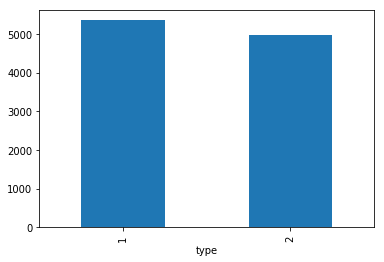

In [64]:
generator_df.groupby('type').size().plot.bar()
# generator_df = generator_df.drop(['class'], axis=1)

In [65]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(generator_df, test_size=0.2)

In [19]:

train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

def create_generator(subset):
    return train_datagen.flow_from_dataframe(
        train, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='type', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(150, 150), 
        color_mode='rgb',
        class_mode='binary', 
        batch_size=16, 
        shuffle=True, 
        seed=2018,
        subset=subset
    )

train_generator = create_generator('training')
valid_generator = create_generator('validation')

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
        test, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='type', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(150, 150), 
        color_mode='rgb',
        class_mode='binary', 
        batch_size=16, 
        shuffle=True, 
        seed=2018
    )

Found 6198 images belonging to 2 classes.
Found 2066 images belonging to 2 classes.
Found 2067 images belonging to 2 classes.


In [20]:
model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu',
#                         input_shape=(224, 224, 3)))

# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(2, activation='softmax'))


model.add(Conv2D(32, 3, 3, border_mode='same', input_shape=(150, 150, 3), activation='relu'))
model.add(Conv2D(32, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(150, 150,..., activation="relu", padding="same")`
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to t

In [21]:
# model.compile(loss='categorical_crossentropy',
#                       optimizer='Adam',
#                       metrics=['accuracy'])

model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(lr=0.0001),
metrics=['accuracy'])

In [24]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=50,
    callbacks=[checkpoint],
    validation_data=valid_generator,
    use_multiprocessing=True,
    validation_steps=STEP_SIZE_VALID,
    workers=2, 
    verbose=1
)

Epoch 1/50
  7/387 [..............................] - ETA: 10:41 - loss: 0.6996 - acc: 0.5179

Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/d

KeyboardInterrupt: 

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('model accuracy')
    plt.xlabel('accuracy')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('model loss')
    plt.xlabel('loss')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [ ]:
loss_and_metrics = model.evaluate_generator(test_generator, STEP_SIZE_TEST)

In [86]:
loss_and_metrics

[1.9710587086219182, 0.7684108527131783]

In [87]:
test_generator.reset()
y_pred = model.predict_generator(test_generator, STEP_SIZE_TEST, verbose=1)
y_pred

129/129 [==============================] - 9s 67ms/step


array([[7.0395768e-03],
       [3.5762787e-06],
       [7.0243609e-01],
       ...,
       [2.0861626e-07],
       [0.0000000e+00],
       [0.0000000e+00]], dtype=float32)

In [88]:
predicted_class_indices = np.argmax(y_pred, axis=1)

In [89]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [93]:
len(filenames)
len(predictions)

2064

In [94]:
filenames = test_generator.filenames[0:2064]
results = pd.DataFrame({'Filename': filenames, 'Predictions' :predictions})
results

,Filename,Predictions
0,02f31f1ba-4.jpg,1
1,b5974bdd0-7.jpg,1
2,ab4ef2577-5.jpg,1
3,8cd96bf75-2.jpg,1
4,072ae6d9e-1.jpg,1
5,621b83ac7-12.jpg,1
6,8cc02d983-1.jpg,1
7,52da0c86c-3.jpg,1
8,de1a20009-12.jpg,1
9,f08b9d3c3-4.jpg,1


In [97]:
from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(test_generator.labels[0:2064], y_pred.argmax(axis=1))

In [98]:
def plot_confusion_matrix(cm, classes, normalize=False, title='confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[: np.newaxis]
        print('normalized confusion matrix')
    else:
        print('unnormalized confusion matrix')
        
    print(cm)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black'
                )
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [99]:
my_labels = ['0', '1']

In [42]:
import itertools 
plot_confusion_matrix(c_matrix, my_labels)

NameError: name 'plot_confusion_matrix' is not defined

# VGG-16


In [20]:
vgg16_model = VGG16()

Instructions for updating:
Colocations handled automatically by placer.


In [21]:
from keras.models import Sequential

model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [22]:
model.layers.pop()

In [23]:
for layer in model.layers:
    layer.trainable = False

In [24]:
model.add(Dense(1, activation='sigmoid'))

In [25]:
model.compile(optimizers.Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

def create_generator(subset):
    return train_datagen.flow_from_dataframe(
        train, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='type', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(224, 224), 
        color_mode='rgb',
        class_mode='binary', 
        batch_size=16, 
        shuffle=True, 
        seed=2018,
        subset=subset
    )

train_generator = create_generator('training')
valid_generator = create_generator('validation')

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
        test, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='type', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(224, 224), 
        color_mode='rgb',
        class_mode='binary', 
        batch_size=16, 
        shuffle=True, 
        seed=2018
    )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=10,
#     callbacks=[checkpoint],
    validation_data=valid_generator,
    use_multiprocessing=True,
    validation_steps=STEP_SIZE_VALID,
    workers=2, 
    verbose=1
)

Found 6198 images belonging to 2 classes.
Found 2066 images belonging to 2 classes.
Found 2067 images belonging to 2 classes.
Epoch 1/10
387/387 [==============================] - 41s 105ms/step - loss: 0.6932 - acc: 0.5011 - val_loss: 0.6933 - val_acc: 0.4981
Epoch 2/10
387/387 [==============================] - 40s 104ms/step - loss: 0.6930 - acc: 0.5173 - val_loss: 0.6927 - val_acc: 0.5233
Epoch 3/10
387/387 [==============================] - 42s 108ms/step - loss: 0.6926 - acc: 0.5185 - val_loss: 0.6924 - val_acc: 0.5226
Epoch 4/10
386/387 [============================>.] - ETA: 0s - loss: 0.6925 - acc: 0.5138

Process ForkPoolWorker-6:
Process ForkPoolWorker-7:
Process ForkPoolWorker-5:
Process ForkPoolWorker-8:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(ma

KeyboardInterrupt: 

Process ForkPoolWorker-9:
Process ForkPoolWorker-10:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/u

# Xception 

In [28]:
xception = Xception(include_top=False, 
                    weights='imagenet', 
                    input_tensor=None, 
                    pooling=None, 
                    classes=2)

x = xception.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)
xception_model = Model(xception.input, predictions)

In [29]:
xception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [30]:
for layer in xception.layers:
    layer.trainable = False
    
xception_model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])

In [32]:
train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

def create_generator(subset):
    return train_datagen.flow_from_dataframe(
        train, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='type', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(299, 299), 
        color_mode='rgb',
        class_mode='binary', 
        batch_size=16, 
        shuffle=True, 
        seed=2018,
        subset=subset
    )

train_generator = create_generator('training')
valid_generator = create_generator('validation')

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
        test, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='type', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(299, 299), 
        color_mode='rgb',
        class_mode='binary', 
        batch_size=16, 
        shuffle=True, 
        seed=2018
    )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

history = xception_model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=10,
#     callbacks=[checkpoint],
    validation_data=valid_generator,
    use_multiprocessing=True,
    validation_steps=STEP_SIZE_VALID,
    workers=2, 
    verbose=1
)

Found 6198 images belonging to 2 classes.
Found 2066 images belonging to 2 classes.
Found 2067 images belonging to 2 classes.
Epoch 1/10
387/387 [==============================] - 68s 175ms/step - loss: 0.2257 - acc: 0.9157 - val_loss: 0.1032 - val_acc: 0.9709
Epoch 2/10
387/387 [==============================] - 66s 171ms/step - loss: 0.1465 - acc: 0.9423 - val_loss: 0.1216 - val_acc: 0.9612
Epoch 3/10
387/387 [==============================] - 67s 173ms/step - loss: 0.1314 - acc: 0.9447 - val_loss: 0.1003 - val_acc: 0.9646
Epoch 4/10
387/387 [==============================] - 68s 176ms/step - loss: 0.1250 - acc: 0.9516 - val_loss: 0.0726 - val_acc: 0.9748
Epoch 5/10
387/387 [==============================] - 68s 176ms/step - loss: 0.1127 - acc: 0.9561 - val_loss: 0.0804 - val_acc: 0.9735
Epoch 6/10
387/387 [==============================] - 68s 176ms/step - loss: 0.1227 - acc: 0.9577 - val_loss: 0.1519 - val_acc: 0.9525
Epoch 7/10
387/387 [==============================] - 67s 174ms/

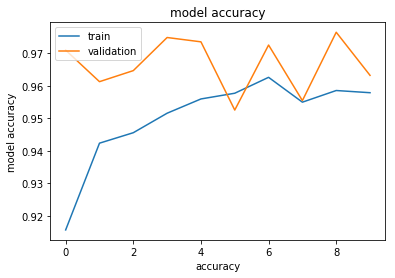

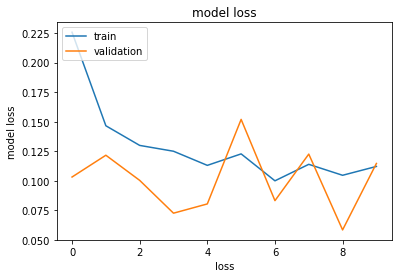

In [35]:
plot_history(history)

In [36]:
loss_and_metrics = xception_model.evaluate_generator(test_generator, STEP_SIZE_TEST)

In [41]:
loss_and_metrics

[0.07439301807122926, 0.9767441860465116]

In [38]:
test_generator.reset()
y_pred = xception_model.predict_generator(test_generator, STEP_SIZE_TEST, verbose=1)
y_pred

129/129 [==============================] - 18s 143ms/step


array([[0.0155926 ],
       [0.97275126],
       [0.99679816],
       ...,
       [0.99929005],
       [0.07767901],
       [0.9996724 ]], dtype=float32)

# XCeption adoption

In [66]:
xception = Xception(include_top=False, 
                    weights='imagenet', 
                    input_tensor=None, 
                    pooling=None, 
                    classes=5)

x = xception.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(5, activation='softmax')(x)
xception_model = Model(xception.input, predictions)

for layer in xception.layers:
    layer.trainable = False
    
xception_model.compile(loss='categorical_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])

train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

def create_generator(subset):
    return train_datagen.flow_from_dataframe(
        train, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='class', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(299, 299), 
        color_mode='rgb',
        class_mode='categorical', 
        batch_size=16, 
        shuffle=True, 
        seed=2018,
        subset=subset
    )

train_generator = create_generator('training')
valid_generator = create_generator('validation')

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
        test, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='class', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(299, 299), 
        color_mode='rgb',
        class_mode='categorical', 
        batch_size=16, 
        shuffle=True, 
        seed=2018
    )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

history = xception_model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=10,
#     callbacks=[checkpoint],
    validation_data=valid_generator,
    use_multiprocessing=True,
    validation_steps=STEP_SIZE_VALID,
    workers=2, 
    verbose=1
)

Found 6198 images belonging to 5 classes.
Found 2066 images belonging to 5 classes.
Found 2067 images belonging to 5 classes.
Epoch 1/10


/usr/lib/python3.7/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


387/387 [==============================] - 68s 175ms/step - loss: 1.4772 - acc: 0.2999 - val_loss: 1.4714 - val_acc: 0.3382
Epoch 2/10
387/387 [==============================] - 66s 171ms/step - loss: 1.4817 - acc: 0.3096 - val_loss: 1.4811 - val_acc: 0.2854
Epoch 3/10
387/387 [==============================] - 66s 172ms/step - loss: 1.3985 - acc: 0.3609 - val_loss: 1.4631 - val_acc: 0.3109
Epoch 4/10
387/387 [==============================] - 70s 181ms/step - loss: 1.4340 - acc: 0.3412 - val_loss: 1.4200 - val_acc: 0.3299
Epoch 5/10
387/387 [==============================] - 71s 183ms/step - loss: 1.3643 - acc: 0.3969 - val_loss: 1.4896 - val_acc: 0.2913
Epoch 6/10
387/387 [==============================] - 71s 184ms/step - loss: 1.4156 - acc: 0.3509 - val_loss: 1.4128 - val_acc: 0.3261
Epoch 7/10
387/387 [==============================] - 71s 183ms/step - loss: 1.3462 - acc: 0.3945 - val_loss: 1.4497 - val_acc: 0.3242
Epoch 8/10
387/387 [==============================] - 70s 182ms/st

# Split by cat and dog


In [75]:
cat_images= generator_df.loc[generator_df['type'] == '2']

In [76]:
cat_images

,filename,class,type
0,0008c5398-1.jpg,3,2
1,0008c5398-5.jpg,3,2
4,0011d7c25-1.jpg,2,2
6,001a1aaad-1.jpg,2,2
7,001b1507c-2.jpg,1,2
8,001b1507c-3.jpg,1,2
9,002278114-10.jpg,1,2
10,002278114-4.jpg,1,2
11,002278114-7.jpg,1,2
15,00553ae55-4.jpg,1,2


In [77]:
cat_train, cat_test = train_test_split(cat_images, test_size=0.2)

In [92]:
xception = Xception(include_top=False, 
                    weights=None, 
                    input_tensor=None, 
                    pooling=None, 
                    classes=5)

x = xception.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(5, activation='softmax')(x)
xception_model = Model(xception.input, predictions)

for layer in xception.layers:
    layer.trainable = False
    
xception_model.compile(loss='categorical_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])

train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

def create_generator(subset):
    return train_datagen.flow_from_dataframe(
        cat_train, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='class', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(299, 299), 
        color_mode='rgb',
        class_mode='categorical', 
        batch_size=16, 
        shuffle=True, 
        seed=2018,
        subset=subset
    )

train_generator = create_generator('training')
valid_generator = create_generator('validation')

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
        cat_test, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='class', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(299, 299), 
        color_mode='rgb',
        class_mode='categorical', 
        batch_size=16, 
        shuffle=True, 
        seed=2018
    )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

history = xception_model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=10,
#     callbacks=[checkpoint],
    validation_data=valid_generator,
    use_multiprocessing=True,
    validation_steps=STEP_SIZE_VALID,
    workers=2, 
    verbose=1
)

Found 2988 images belonging to 5 classes.
Found 996 images belonging to 5 classes.
Found 996 images belonging to 5 classes.
Epoch 1/10
186/186 [==============================] - 42s 225ms/step - loss: 1.5485 - acc: 0.2648 - val_loss: 1.6074 - val_acc: 0.3024
Epoch 2/10
186/186 [==============================] - 34s 183ms/step - loss: 1.5126 - acc: 0.2809 - val_loss: 1.6087 - val_acc: 0.2903
Epoch 3/10
186/186 [==============================] - 34s 182ms/step - loss: 1.4894 - acc: 0.3025 - val_loss: 1.6088 - val_acc: 0.2975
Epoch 4/10
186/186 [==============================] - 34s 184ms/step - loss: 1.5266 - acc: 0.2702 - val_loss: 1.6080 - val_acc: 0.2984
Epoch 5/10
186/186 [==============================] - 34s 183ms/step - loss: 1.4978 - acc: 0.3057 - val_loss: 1.6082 - val_acc: 0.2810
Epoch 6/10
186/186 [==============================] - 34s 184ms/step - loss: 1.5520 - acc: 0.2819 - val_loss: 1.6080 - val_acc: 0.3125
Epoch 7/10
186/186 [==============================] - 34s 184ms/st

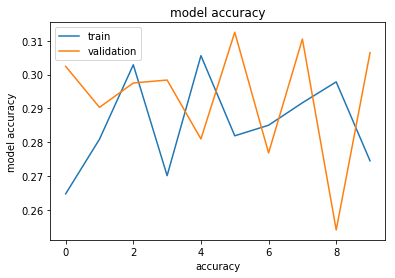

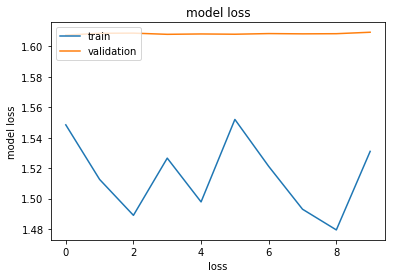

In [93]:
plot_history(history)

In [94]:
loss_and_metrics = xception_model.evaluate_generator(test_generator, STEP_SIZE_TEST)
loss_and_metrics

[1.609442393625936, 0.2933467741935484]

In [81]:
dog_images= generator_df.loc[generator_df['type'] == '1']

In [82]:
dog_train, dog_test = train_test_split(dog_images, test_size=0.2)

In [89]:
xception = Xception(include_top=False, 
                    weights=None, 
                    input_tensor=None, 
                    pooling=None, 
                    classes=5)

x = xception.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(5, activation='softmax')(x)
xception_model = Model(xception.input, predictions)

for layer in xception.layers:
    layer.trainable = False
    
xception_model.compile(loss='categorical_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])

train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

def create_generator(subset):
    return train_datagen.flow_from_dataframe(
        dog_train, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='class', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(299, 299), 
        color_mode='rgb',
        class_mode='categorical', 
        batch_size=16, 
        shuffle=True, 
        seed=2018,
        subset=subset
    )

train_generator = create_generator('training')
valid_generator = create_generator('validation')

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
        dog_test, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='class', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(299, 299), 
        color_mode='rgb',
        class_mode='categorical', 
        batch_size=16, 
        shuffle=True, 
        seed=2018
    )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

history = xception_model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=10,
#     callbacks=[checkpoint],
    validation_data=valid_generator,
    use_multiprocessing=True,
    validation_steps=STEP_SIZE_VALID,
    workers=2, 
    verbose=1
)

Found 3210 images belonging to 5 classes.
Found 1070 images belonging to 5 classes.
Found 1071 images belonging to 5 classes.
Epoch 1/10
200/200 [==============================] - 42s 208ms/step - loss: 1.4685 - acc: 0.2872 - val_loss: 1.6069 - val_acc: 0.3011
Epoch 2/10
200/200 [==============================] - 35s 177ms/step - loss: 1.4645 - acc: 0.2984 - val_loss: 1.6073 - val_acc: 0.2765
Epoch 3/10
200/200 [==============================] - 36s 182ms/step - loss: 1.4653 - acc: 0.2870 - val_loss: 1.6063 - val_acc: 0.2890
Epoch 4/10
200/200 [==============================] - 37s 185ms/step - loss: 1.4682 - acc: 0.3028 - val_loss: 1.6068 - val_acc: 0.2879
Epoch 5/10
200/200 [==============================] - 37s 186ms/step - loss: 1.4507 - acc: 0.2902 - val_loss: 1.6061 - val_acc: 0.1635
Epoch 6/10
200/200 [==============================] - 37s 185ms/step - loss: 1.4519 - acc: 0.3066 - val_loss: 1.6058 - val_acc: 0.2803
Epoch 7/10
200/200 [==============================] - 37s 185ms/

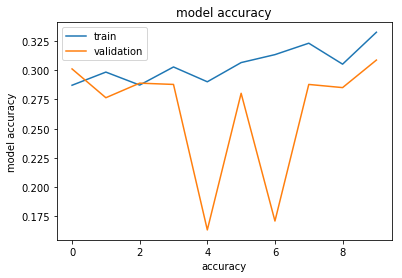

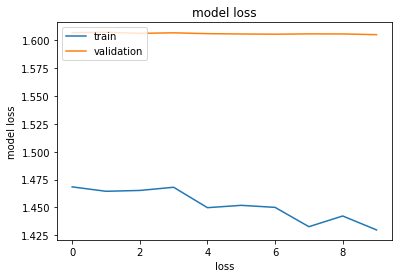

In [90]:
plot_history(history)

In [91]:
loss_and_metrics = xception_model.evaluate_generator(test_generator, STEP_SIZE_TEST)
loss_and_metrics

[1.6051281184861155, 0.26704545454545453]

# My CNN

In [105]:

train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

def create_generator(subset):
    return train_datagen.flow_from_dataframe(
        cat_train, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='class', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(150, 150), 
        color_mode='rgb',
        class_mode='categorical', 
        batch_size=16, 
        shuffle=True, 
        seed=2018,
        subset=subset
    )

train_generator = create_generator('training')
valid_generator = create_generator('validation')

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
        cat_test, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='class', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(150, 150), 
        color_mode='rgb',
        class_mode='categorical', 
        batch_size=16, 
        shuffle=True, 
        seed=2018
    )

model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu',
#                         input_shape=(150, 150, 3)))

# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(5, activation='softmax'))


model.add(Conv2D(32, 3, 3, border_mode='same', input_shape=(150, 150, 3), activation='relu'))
model.add(Conv2D(32, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(512, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(1024, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(1024, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))


model.compile(loss='categorical_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=50,
#     callbacks=[checkpoint],
    validation_data=valid_generator,
    use_multiprocessing=True,
    validation_steps=STEP_SIZE_VALID,
    workers=2, 
    verbose=1
)

Found 2988 images belonging to 5 classes.
Found 996 images belonging to 5 classes.
Found 996 images belonging to 5 classes.


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(150, 150,..., activation="relu", padding="same")`
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Update your `Conv2D` call to t

Epoch 1/50


/usr/lib/python3.7/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


186/186 [==============================] - 26s 138ms/step - loss: 1.5030 - acc: 0.2732 - val_loss: 1.4907 - val_acc: 0.3024
Epoch 2/50
186/186 [==============================] - 17s 93ms/step - loss: 1.4797 - acc: 0.2735 - val_loss: 1.4731 - val_acc: 0.2903
Epoch 3/50
186/186 [==============================] - 18s 96ms/step - loss: 1.4735 - acc: 0.3049 - val_loss: 1.4858 - val_acc: 0.2975
Epoch 4/50
186/186 [==============================] - 18s 98ms/step - loss: 1.4803 - acc: 0.2839 - val_loss: 1.4672 - val_acc: 0.2984
Epoch 5/50
186/186 [==============================] - 18s 96ms/step - loss: 1.4745 - acc: 0.2844 - val_loss: 1.4609 - val_acc: 0.2841
Epoch 6/50
186/186 [==============================] - 18s 98ms/step - loss: 1.4798 - acc: 0.2991 - val_loss: 1.4758 - val_acc: 0.3095
Epoch 7/50
186/186 [==============================] - 18s 98ms/step - loss: 1.4858 - acc: 0.2838 - val_loss: 1.4939 - val_acc: 0.2769
Epoch 8/50
186/186 [==============================] - 18s 98ms/step - lo

Process ForkPoolWorker-71:
Process ForkPoolWorker-72:
Process ForkPoolWorker-69:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-70:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/usr/lib/python3.7/site-packages/keras/utils/data_utils.py", line 626, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/l

KeyboardInterrupt: 

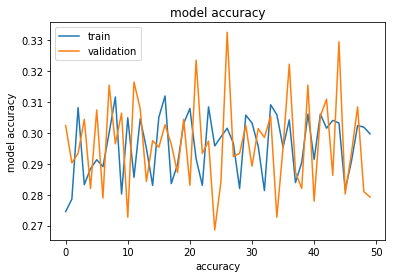

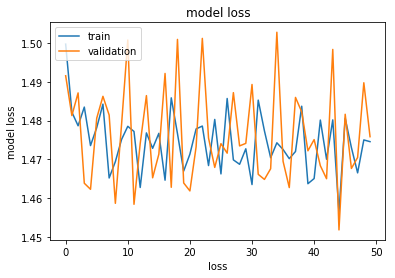

In [99]:
plot_history(history)

# InceptionV3

In [109]:
base_model = InceptionV3(weights='imagenet', include_top=False)

CLASSES = 5

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [110]:

train_datagen=ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.25,
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

def create_generator(subset):
    return train_datagen.flow_from_dataframe(
        cat_train, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='class', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(150, 150), 
        color_mode='rgb',
        class_mode='categorical', 
        batch_size=16, 
        shuffle=True, 
        seed=2018,
        subset=subset
    )

train_generator = create_generator('training')
valid_generator = create_generator('validation')

test_datagen=ImageDataGenerator(
    rescale=1./255.,
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_generator = test_datagen.flow_from_dataframe(
        cat_test, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='class', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(150, 150), 
        color_mode='rgb',
        class_mode='categorical', 
        batch_size=16, 
        shuffle=True, 
        seed=2018
    )

Found 2988 images belonging to 5 classes.
Found 996 images belonging to 5 classes.
Found 996 images belonging to 5 classes.


In [111]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=5,
#     callbacks=[checkpoint],
    validation_data=valid_generator,
    use_multiprocessing=True,
    validation_steps=STEP_SIZE_VALID,
    workers=2, 
    verbose=1
)

Epoch 1/5
186/186 [==============================] - 26s 140ms/step - loss: 1.7542 - acc: 0.2638 - val_loss: 1.5381 - val_acc: 0.2843
Epoch 2/5
186/186 [==============================] - 14s 76ms/step - loss: 1.6986 - acc: 0.2749 - val_loss: 1.5320 - val_acc: 0.2823
Epoch 3/5
186/186 [==============================] - 15s 81ms/step - loss: 1.6302 - acc: 0.2909 - val_loss: 1.5540 - val_acc: 0.2893
Epoch 4/5
186/186 [==============================] - 15s 79ms/step - loss: 1.7191 - acc: 0.2812 - val_loss: 1.5314 - val_acc: 0.2812
Epoch 5/5
186/186 [==============================] - 14s 78ms/step - loss: 1.7065 - acc: 0.2839 - val_loss: 1.5146 - val_acc: 0.2758


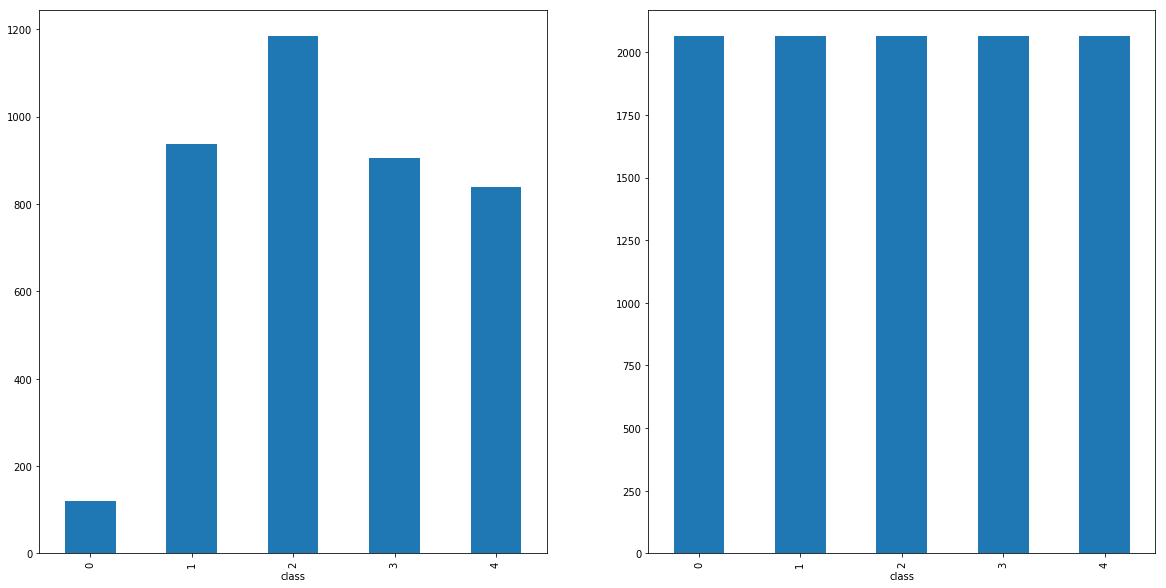

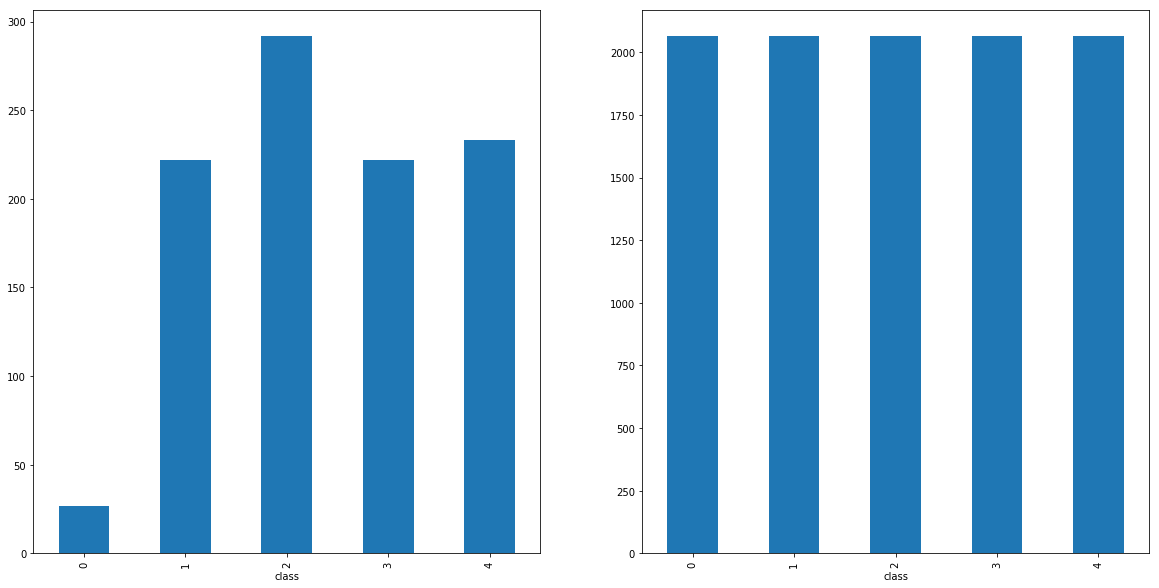

In [114]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
cat_train.groupby('class').size().plot.bar(ax=ax1)
cat_train_df = cat_train.groupby('class').apply(lambda x: x.sample(10331//5, replace=True)).reset_index(drop=True)
cat_train_df.groupby('class').size().plot.bar(ax=ax2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
cat_test.groupby('class').size().plot.bar(ax=ax1)
cat_test_df = cat_test.groupby('class').apply(lambda x: x.sample(10331//5, replace=True)).reset_index(drop=True)
cat_test_df.groupby('class').size().plot.bar(ax=ax2)

In [122]:
base_model = InceptionV3(weights='imagenet', include_top=False)

CLASSES = 5

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [123]:

train_datagen=ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.25,
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

def create_generator(subset):
    return train_datagen.flow_from_dataframe(
        cat_train_df, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='class', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(224, 224), 
        color_mode='rgb',
        class_mode='categorical', 
        batch_size=16, 
        shuffle=True, 
        seed=2018,
        subset=subset
    )

train_generator = create_generator('training')
valid_generator = create_generator('validation')

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
        cat_test_df, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='class', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(224, 224), 
        color_mode='rgb',
        class_mode='categorical', 
        batch_size=16, 
        shuffle=True, 
        seed=2018
    )

Found 2654 images belonging to 5 classes.
Found 884 images belonging to 5 classes.
Found 996 images belonging to 5 classes.


In [124]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=50,
#     callbacks=[checkpoint],
    validation_data=valid_generator,
#     use_multiprocessing=True,
    validation_steps=STEP_SIZE_VALID,
    workers=2, 
    verbose=1
)

Epoch 1/50


/usr/lib/python3.7/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


165/165 [==============================] - 36s 218ms/step - loss: 1.3931 - acc: 0.3436 - val_loss: 2.8252 - val_acc: 0.0000e+00
Epoch 2/50
165/165 [==============================] - 20s 120ms/step - loss: 1.3217 - acc: 0.3485 - val_loss: 3.1917 - val_acc: 0.0000e+00
Epoch 3/50
165/165 [==============================] - 20s 119ms/step - loss: 1.3105 - acc: 0.3698 - val_loss: 3.0167 - val_acc: 0.0000e+00
Epoch 4/50
165/165 [==============================] - 20s 118ms/step - loss: 1.3239 - acc: 0.3780 - val_loss: 3.1234 - val_acc: 0.0000e+00
Epoch 5/50
165/165 [==============================] - 20s 121ms/step - loss: 1.2613 - acc: 0.3885 - val_loss: 3.4078 - val_acc: 0.0000e+00
Epoch 6/50
165/165 [==============================] - 20s 118ms/step - loss: 1.3779 - acc: 0.3527 - val_loss: 2.9340 - val_acc: 0.0000e+00
Epoch 7/50
165/165 [==============================] - 19s 118ms/step - loss: 1.2906 - acc: 0.3906 - val_loss: 3.1681 - val_acc: 0.0000e+00
Epoch 8/50
165/165 [==================

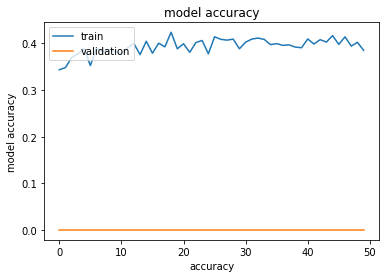

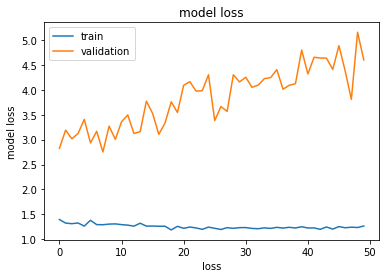

In [125]:
plot_history(history)

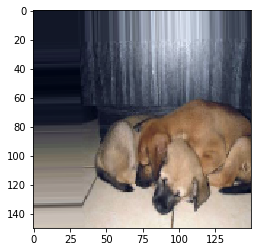

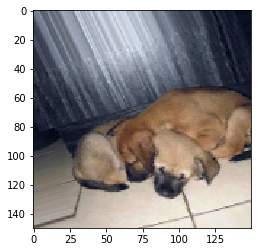

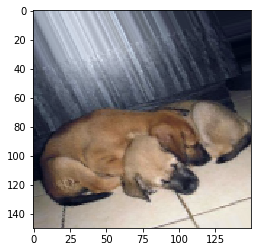

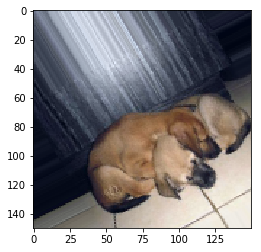

In [121]:
from keras.preprocessing import image

fnames = [os.path.join('../pet_data/train_images/', fname) for
         fname in os.listdir('../pet_data/train_images/')]

img_path = fnames[6]
img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i =0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
        
plt.show()

# Xception 

In [126]:
xception = Xception(include_top=False, 
                    weights='imagenet', 
                    input_tensor=None, 
                    pooling=None, 
                    classes=5)

x = xception.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(5, activation='softmax')(x)
xception_model = Model(xception.input, predictions)

for layer in xception.layers:
    layer.trainable = False
    
xception_model.compile(loss='categorical_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])

train_datagen=ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.25,
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

def create_generator(subset):
    return train_datagen.flow_from_dataframe(
        cat_train_df, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='class', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(299, 299), 
        color_mode='rgb',
        class_mode='categorical', 
        batch_size=16, 
        shuffle=True, 
        seed=2018,
        subset=subset
    )

train_generator = create_generator('training')
valid_generator = create_generator('validation')

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
        cat_test_df, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='class', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(299, 299), 
        color_mode='rgb',
        class_mode='categorical', 
        batch_size=16, 
        shuffle=True, 
        seed=2018
    )

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

history = xception_model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=50,
#     callbacks=[checkpoint],
    validation_data=valid_generator,
#     use_multiprocessing=True,
    validation_steps=STEP_SIZE_VALID,
    workers=2, 
    verbose=1
)

Found 2654 images belonging to 5 classes.
Found 884 images belonging to 5 classes.
Found 996 images belonging to 5 classes.
Epoch 1/50
165/165 [==============================] - 47s 285ms/step - loss: 1.2203 - acc: 0.3731 - val_loss: 2.5049 - val_acc: 0.0000e+00
Epoch 2/50
165/165 [==============================] - 31s 191ms/step - loss: 1.1949 - acc: 0.3954 - val_loss: 2.3032 - val_acc: 0.0000e+00
Epoch 3/50
165/165 [==============================] - 30s 185ms/step - loss: 1.1792 - acc: 0.4004 - val_loss: 2.2645 - val_acc: 0.0000e+00
Epoch 4/50
165/165 [==============================] - 31s 185ms/step - loss: 1.1627 - acc: 0.4194 - val_loss: 2.3609 - val_acc: 0.0000e+00
Epoch 5/50
165/165 [==============================] - 30s 185ms/step - loss: 1.1609 - acc: 0.4223 - val_loss: 2.4172 - val_acc: 0.0000e+00
Epoch 6/50
165/165 [==============================] - 31s 186ms/step - loss: 1.1399 - acc: 0.4356 - val_loss: 2.4551 - val_acc: 0.0000e+00
Epoch 7/50
165/165 [======================

KeyboardInterrupt: 

# NasNet Large

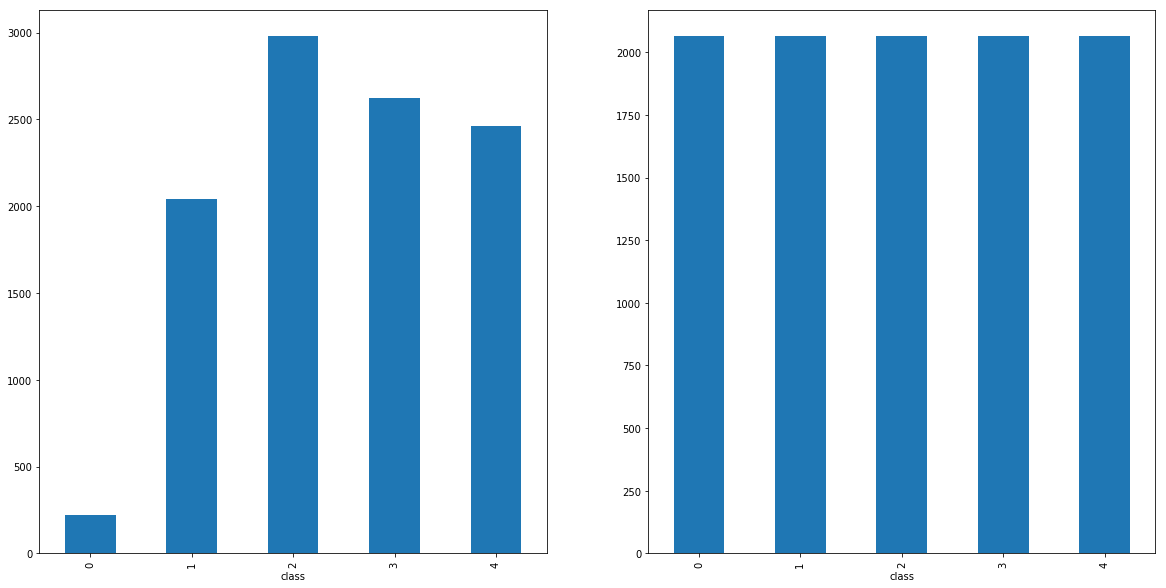

In [130]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
generator_df.groupby('class').size().plot.bar(ax=ax1)
train_df = generator_df.groupby('class').apply(lambda x: x.sample(10331//5, replace=True)).reset_index(drop=True)
train_df.groupby('class').size().plot.bar(ax=ax2)


In [133]:
train, test = train_test_split(train_df, test_size=0.2)

In [131]:
nasnet = NASNetLarge(include_top=False, 
                    weights='imagenet', 
                    input_tensor=None, 
                    pooling=None, 
                    classes=5)

x = nasnet.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(5, activation='softmax')(x)
nasnet_model = Model(nasnet.input, predictions)
nasnet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 331, 331, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_17[0][0]                   
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_637 (Activation)     (None, 165, 165, 96) 0           stem_bn1[0][0]                   
__________________________________________________________________________________________________
reduction_

In [136]:
for layer in nasnet.layers:
    layer.trainable = False
    
nasnet_model.compile(loss='categorical_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])

In [137]:
train_datagen=ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.25,
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

def create_generator(subset):
    return train_datagen.flow_from_dataframe(
        train, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='class', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(331, 331), 
        color_mode='rgb',
        class_mode='categorical', 
        batch_size=16, 
        shuffle=True, 
        seed=2018,
        subset=subset
    )

train_generator = create_generator('training')
valid_generator = create_generator('validation')

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
        test, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='class', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(331, 331), 
        color_mode='rgb',
        class_mode='categorical', 
        batch_size=16, 
        shuffle=True, 
        seed=2018
    )

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

history = nasnet_model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=10,
#     callbacks=[checkpoint],
    validation_data=valid_generator,
#     use_multiprocessing=True,
    validation_steps=STEP_SIZE_VALID,
    workers=2, 
    verbose=1
)

Found 3767 images belonging to 5 classes.
Found 1255 images belonging to 5 classes.
Found 1727 images belonging to 5 classes.
Epoch 1/10
235/235 [==============================] - 203s 862ms/step - loss: 1.5117 - acc: 0.2896 - val_loss: 1.6625 - val_acc: 0.1979
Epoch 2/10
235/235 [==============================] - 165s 702ms/step - loss: 1.4396 - acc: 0.3334 - val_loss: 1.6501 - val_acc: 0.2074
Epoch 3/10
235/235 [==============================] - 164s 698ms/step - loss: 1.4279 - acc: 0.3509 - val_loss: 1.7017 - val_acc: 0.2389
Epoch 4/10
235/235 [==============================] - 164s 698ms/step - loss: 1.3953 - acc: 0.3771 - val_loss: 1.6535 - val_acc: 0.2268
Epoch 5/10
235/235 [==============================] - 164s 696ms/step - loss: 1.3643 - acc: 0.3735 - val_loss: 1.6624 - val_acc: 0.2276
Epoch 6/10
235/235 [==============================] - 164s 699ms/step - loss: 1.3581 - acc: 0.3920 - val_loss: 1.6796 - val_acc: 0.2341
Epoch 7/10
235/235 [==============================] - 164s

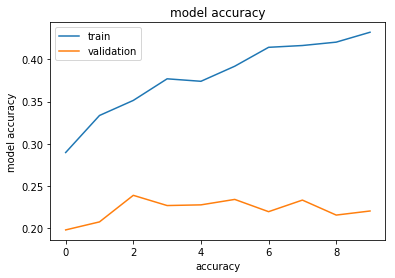

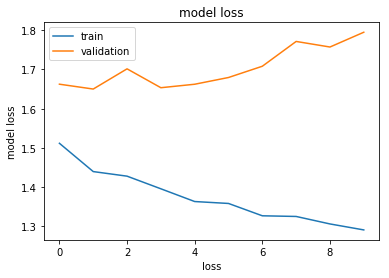

In [138]:
plot_history(history)

In [139]:
xception = Xception(include_top=False, 
                    weights='imagenet', 
                    input_tensor=None, 
                    pooling=None, 
                    classes=5)

x = xception.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(5, activation='softmax')(x)
xception_model = Model(xception.input, predictions)

for layer in xception.layers:
    layer.trainable = False
    
xception_model.compile(loss='categorical_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])

train_datagen=ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.25,
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

def create_generator(subset):
    return train_datagen.flow_from_dataframe(
        train, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='class', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(299, 299), 
        color_mode='rgb',
        class_mode='categorical', 
        batch_size=16, 
        shuffle=True, 
        seed=2018,
        subset=subset
    )

train_generator = create_generator('training')
valid_generator = create_generator('validation')

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
        test, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='class', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(299, 299), 
        color_mode='rgb',
        class_mode='categorical', 
        batch_size=16, 
        shuffle=True, 
        seed=2018
    )

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

history = xception_model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=20,
#     callbacks=[checkpoint],
    validation_data=valid_generator,
#     use_multiprocessing=True,
    validation_steps=STEP_SIZE_VALID,
    workers=2, 
    verbose=1
)

Found 3767 images belonging to 5 classes.
Found 1255 images belonging to 5 classes.
Found 1727 images belonging to 5 classes.
Epoch 1/20
235/235 [==============================] - 83s 353ms/step - loss: 1.4782 - acc: 0.2870 - val_loss: 1.6149 - val_acc: 0.2220
Epoch 2/20
235/235 [==============================] - 45s 194ms/step - loss: 1.4468 - acc: 0.3065 - val_loss: 1.6219 - val_acc: 0.2236
Epoch 3/20
235/235 [==============================] - 46s 196ms/step - loss: 1.4216 - acc: 0.3329 - val_loss: 1.5958 - val_acc: 0.2365
Epoch 4/20
235/235 [==============================] - 46s 196ms/step - loss: 1.4059 - acc: 0.3435 - val_loss: 1.5963 - val_acc: 0.2437
Epoch 5/20
235/235 [==============================] - 46s 197ms/step - loss: 1.3857 - acc: 0.3594 - val_loss: 1.6310 - val_acc: 0.2486
Epoch 6/20
235/235 [==============================] - 46s 197ms/step - loss: 1.3882 - acc: 0.3641 - val_loss: 1.6164 - val_acc: 0.2365
Epoch 7/20
235/235 [==============================] - 46s 198ms/